### Load and import stuff

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pathlib import Path
from pprint import pprint
from tqdm import tqdm
import featuretools as ft
from joblib import dump, load
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import MinMaxScaler, minmax_scale, scale, power_transform, quantile_transform, normalize 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from  sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from tensorflow.keras import layers,models,metrics,callbacks,losses
from tensorflow.keras.activations import relu,sigmoid,swish,tanh,selu
from tensorflow.keras.optimizers import SGD,Adam,RMSprop,Adadelta,Nadam
from tensorflow.keras.models import Model, Sequential,load_model
import tensorflow as tf

RANDOM_SEED = 777
np.random.seed(RANDOM_SEED)
import warnings
warnings.filterwarnings(
    action='ignore',
)

C:\Users\kurma\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
metadata = pd.read_csv('data/metadata.csv')
train_labels = pd.read_csv('data/train_labels.csv', index_col="sample_id")
val_labels = pd.read_csv('data/val_labels.csv',index_col='sample_id')
submission_format = pd.read_csv('data/submission_format.csv')

In [6]:
train_df = pd.read_csv('data/train_df.csv',index_col=0,header=[0,1])
train_df.sort_index(inplace=True,axis=1)
train_df.head()

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0000           0.0  0.004085   0.004641     0.000000          0.0   
S0001           0.0  0.000000   0.000000     0.000000          0.0   
S0002           0.0  0.002270   0.002495     0.000000          0.0   
S0003           0.0  0.001336   0.002464     0.000306          0.0   
S0004           0.0  0.005993   0.012429     0.000593          0.0   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0000              0.0          0.0          0.0   0.001394   0.000188  ...   
S0001              0.0          0.0          0.0   0.000000   0.000000  ...   
S0002              0.0          0.0          0.0   0.001688   0.000636  ...   
S0003              0.0          0.0          0.0   0.001099   0.000992  ...   
S0004              0.0          0.0          0.0   0.009380   0.005099  ...   

m/z                 99                                                   \
temp_bin  (1300, 1400] (1400, 1500]    (200, 300] (300, 400] (400, 500]   
sample_id                                                                 
S0000              0.0          0.0  2.898509e-06   0.000003   0.000000   
S0001              0.0          0.0  0.000000e+00   0.000000   0.000000   
S0002              0.0          0.0  9.257968e-07   0.000001   0.000001   
S0003              0.0          0.0  4.379099e-06   0.000006   0.000005   
S0004              0.0          0.0  3.904920e-06   0.000004   0.000004   

m/z                                                                   
temp_bin  (500, 600]    (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                             
S0000       0.000000  0.000000e+00   0.000000   0.000000    0.000000  
S0001       0.000000  0.000000e+00   0.000000   0.000000    0.000000  
S0002       0.000001  9.397170e-07   0.000001   0.000001    0.000001  
S0003       0.000005  4.693477e-06   0.000004   0.000004    0.000004  
S0004       0.000005  3.174421e-06   0.000004   0.000004    0.000003  

[5 rows x 1600 columns]

In [7]:
test_df = pd.read_csv('data/test_df.csv',index_col=0,header=[0,1])
test_df.sort_index(inplace=True,axis=1)
test_df.head()

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S1059           0.0  0.000284   0.001057     0.001710     0.001519   
S1060           0.0  0.000000   0.000000     0.000000     0.000000   
S1061           0.0  0.041784   0.041511     0.000000     0.000000   
S1062           0.0  0.237662   0.202370     0.150181     0.000000   
S1063           0.0  0.005983   0.012425     0.000642     0.000000   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S1059         0.001535          0.0          0.0   0.001821   0.002638  ...   
S1060         0.000000          0.0          0.0   0.000000   0.000000  ...   
S1061         0.000000          0.0          0.0   0.041296   0.037546  ...   
S1062         0.000000          0.0          0.0   0.230153   0.228463  ...   
S1063         0.000000          0.0          0.0   0.009031   0.004695  ...   

m/z                 99                                                \
temp_bin  (1300, 1400] (1400, 1500] (200, 300] (300, 400] (400, 500]   
sample_id                                                              
S1059              0.0          0.0   0.000022   0.000023   0.000023   
S1060              0.0          0.0   0.000000   0.000000   0.000000   
S1061              0.0          0.0   0.000493   0.000545   0.000427   
S1062              0.0          0.0   0.000994   0.000989   0.001457   
S1063              0.0          0.0   0.000004   0.000003   0.000004   

m/z                                                                
temp_bin  (500, 600] (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                          
S1059       0.000024   0.000022   0.000021   0.000020    0.000026  
S1060       0.000000   0.000000   0.000000   0.000000    0.000000  
S1061       0.000516   0.000633   0.000595   0.000437    0.000483  
S1062       0.001092   0.001113   0.000860   0.001161    0.000935  
S1063       0.000004   0.000003   0.000004   0.000004    0.000003  

[5 rows x 1600 columns]

In [8]:
sam_id = metadata[metadata.instrument_type == 'sam_testbed'].index
sam_id

Int64Index([ 754,  755,  756,  757,  758,  759,  760,  761,  762,  763,  764,
             765, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515,
            1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526,
            1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537,
            1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548,
            1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559,
            1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569],
           dtype='int64')

In [9]:
metadata[metadata["split"] == "test"]

,sample_id,split,instrument_type,features_path,features_md5_hash
1059,S1059,test,commercial,test_features/S1059.csv,ae61bd820b8792b78629d6f7295d0dc8
1060,S1060,test,commercial,test_features/S1060.csv,cbdb1b287eadf640d653e4e2802a1d33
1061,S1061,test,commercial,test_features/S1061.csv,66774327b7351ab2f9e9b2d003616653
1062,S1062,test,commercial,test_features/S1062.csv,9b1d99fbbc0e12d6441fc849f9ac76a3
1063,S1063,test,commercial,test_features/S1063.csv,abfe1d433b1375d54ca916d14bcd3dc7
...,...,...,...,...,...
1565,S1565,test,sam_testbed,test_features/S1565.csv,3146a38af69bb12aff54b9cd1e2c49e8
1566,S1566,test,sam_testbed,test_features/S1566.csv,239d0687ec42966d80394c7b206c23df
1567,S1567,test,sam_testbed,test_features/S1567.csv,040585537a39523a582af874ff2f3b3d
1568,S1568,test,sam_testbed,test_features/S1568.csv,6211107e4f0eedcdc5750cd27f57d4fa


### Binning

In [10]:
train_files = metadata[metadata["split"] == "train"]["features_path"].to_dict()
val_files = metadata[metadata["split"] == "val"]["features_path"].to_dict()
test_files = metadata[metadata["split"] == "test"]["features_path"].to_dict()

print("Number of training samples: ", len(train_files))
print("Number of validation samples: ", len(val_files))
print("Number of testing samples: ", len(test_files))

Number of training samples:  766
Number of validation samples:  293
Number of testing samples:  511


In [1]:
def drop_frac_and_He(df):
    """
    Drops fractional m/z values, m/z values > 100, and carrier gas m/z

    Args:
        df: a dataframe representing a single sample, containing m/z values

    Returns:
        The dataframe without fractional an carrier gas m/z
    """

    # drop fractional m/z values
    df = df[df["m/z"].transform(round) == df["m/z"]]
    assert df["m/z"].apply(float.is_integer).all(), "not all m/z are integers"

    # drop m/z values greater than 99
    df = df[df["m/z"] < 100]

    # # drop carrier gas
    # df = df[df["m/z"] != 4]
    
    return df

def remove_background_abundance(df):
    """
    Subtracts minimum abundance value

    Args:
        df: dataframe with 'm/z' and 'abundance' columns

    Returns:
        dataframe with minimum abundance subtracted for all observations
    """

    df["abundance_minsub"] = df.groupby(["m/z"])["abundance"].transform(
        lambda x: (x - x.min())
    )

    return df
    
def scale_abun(df):
    """
    Scale abundance from 0-100 according to the min and max values across entire sample

    Args:
        df: dataframe containing abundances and m/z

    Returns:
        dataframe with additional column of scaled abundances
    """
    # v1 =  naive qt transformation (uniform distribution)
    # v2 =  min-max scaling + qt transformation
    # v3 = qt transformation based on groupby mz

    # # add relative abundance
    # df['abun_minsub_scaled'] = 0
    # mzgroups = df.groupby(["m/z"])
    # for i in  range(99):
    #     try:
    #         he_abund = mzgroups.get_group(4)['abundance_minsub'].values 
    #         x = mzgroups.get_group(i)['abundance_minsub'].values
    #         x_id = mzgroups.get_group(i).index
    #         df.loc[x_id,"abun_minsub_scaled"] = he_abund - x
    #     except:
    #         print('mz group not found')
            

    # df["abun_minsub_scaled"] = df["abundance_minsub"].astype(float) 
    
    # df["abun_minsub_scaled"] = quantile_transform(df["abundance_minsub"].astype(float).values.reshape(-1,1),output_distribution='uniform',random_state=RANDOM_SEED)
    df["abun_minsub_scaled"] = minmax_scale(df["abundance_minsub"].astype(float))

    # display(df.groupby(['m/z'])['abun_minsub_scaled'].groups.keys())

    return df

In [2]:
# Preprocess function
def preprocess_sample(df):
    df = drop_frac_and_He(df)
    df = remove_background_abundance(df)
    df = scale_abun(df)
    return df

In [11]:
# Create a series of temperature bins
temprange = pd.interval_range(start=-100, end=2000, freq=100)
temprange

# Make dataframe with rows that are combinations of all temperature bins
# and all m/z values
allcombs = list(itertools.product(temprange, [*range(0, 100)]))

allcombs_df = pd.DataFrame(allcombs, columns=["time_bin", "m/z"])
print(allcombs_df.shape)
allcombs_df.head()

(2100, 2)


,time_bin,m/z
0,"(-100, 0]",0
1,"(-100, 0]",1
2,"(-100, 0]",2
3,"(-100, 0]",3
4,"(-100, 0]",4


In [12]:
def abun_per_tempbin(df):

    """
    Transforms dataset to take the preprocessed max abundance for each
    temperature range for each m/z value

    Args:
        df: dataframe to transform

    Returns:
        transformed dataframe
    """
    
    # Bin temperatures
    df["time_bin"] = pd.cut(df["time"], bins=temprange)

    # Combine with a list of all temp bin-m/z value combinations
    df = pd.merge(allcombs_df, df, on=["time_bin", "m/z"], how="left")

    # Aggregate to temperature bin level to find max
    df = df.groupby(["time_bin", "m/z"]).max("abun_minsub_scaled").reset_index()

    # Fill in 0 for abundance values without information
    df = df.replace(np.nan, 0)

    # Reshape so each row is a single sample
    df = df.pivot_table(columns=["m/z", "time_bin"], values=["abun_minsub_scaled"])

    return df

In [13]:
def sam_2_com(df):
    df['abundance'] = df['abundance']*1.60217646 * 10**-19
    df['time'] = minmax_scale(df['time'],feature_range=(0,1800))
    df['temp'] = minmax_scale(df['temp'],feature_range=(0,1200))
    return df

In [14]:
# Assembling preprocessed and transformed training set

train_features_dict = {}
print("Total number of train files: ", len(train_files))

for i, (sample_id, filepath) in enumerate(tqdm(train_files.items())):

    # Load training sample
    temp = pd.read_csv('data/' + filepath)
    
    if sample_id in sam_id:
        temp = sam_2_com(temp)

    # Preprocessing training sample
    train_sample_pp = preprocess_sample(temp)

    # Feature engineering
    train_sample_fe = abun_per_tempbin(train_sample_pp).reset_index(drop=True)
    train_features_dict[sample_id] = train_sample_fe

train_features = pd.concat(
    train_features_dict, names=["sample_id", "dummy_index"]
).reset_index(level="dummy_index", drop=True)

  0%|          | 0/766 [00:00<?, ?it/s]

Total number of train files:  766


100%|██████████| 766/766 [04:26<00:00,  2.87it/s]


In [26]:
he = train_features.groupby(level=0,axis=1).get_group(4)

In [30]:
(he.sum(axis=1) == 0).sum()

sample_id
0      False
1      False
2      False
3      False
4      False
       ...  
761     True
762     True
763     True
764     True
765     True
Length: 766, dtype: bool

In [35]:
(train_features.sum(axis=1) == 0).sum()

0

In [31]:
# Assembling preprocessed and transformed valing set

val_features_dict = {}
print("Total number of val files: ", len(val_files))

for i, (sample_id, filepath) in enumerate(tqdm(val_files.items())):

    # Load valing sample
    temp = pd.read_csv('data/' + filepath)

    # map sam samples to com samples
    if sample_id in sam_id:
        temp = sam_2_com(temp)
        
    # Preprocessing valing sample
    val_sample_pp = preprocess_sample(temp)

    # Feature engineering
    val_sample_fe = abun_per_tempbin(val_sample_pp).reset_index(drop=True)
    val_features_dict[sample_id] = val_sample_fe

val_features = pd.concat(
    val_features_dict, names=["sample_id", "dummy_index"]
).reset_index(level="dummy_index", drop=True)

  0%|          | 0/293 [00:00<?, ?it/s]

Total number of val files:  293


100%|██████████| 293/293 [01:28<00:00,  3.32it/s]


In [34]:
(val_features.sum(axis=1) == 0).sum()

0

In [32]:
val_features.groupby(level=0,axis=1).get_group(4).sum(axis=1)

sample_id
766     13.160267
767     14.882365
768      9.808837
769      8.628025
770      2.491327
          ...    
1054    14.293325
1055    11.994311
1056     1.577611
1057     1.374186
1058     2.951771
Length: 293, dtype: float64

In [36]:
# Assembling preprocessed and transformed testing set

test_features_dict = {}
print("Total number of test files: ", len(test_files))

for i, (sample_id, filepath) in enumerate(tqdm(test_files.items())):

    # Load testing sample
    temp = pd.read_csv('data/' + filepath)

    # map sam samples to com samples
    if sample_id in sam_id:
        temp = sam_2_com(temp)

    # Preprocessing testing sample
    test_sample_pp = preprocess_sample(temp)

    # Feature engineering
    test_sample_fe = abun_per_tempbin(test_sample_pp).reset_index(drop=True)
    test_features_dict[sample_id] = test_sample_fe

test_features = pd.concat(
    test_features_dict, names=["sample_id", "dummy_index"]
).reset_index(level="dummy_index", drop=True)

  0%|          | 0/511 [00:00<?, ?it/s]

Total number of test files:  511


100%|██████████| 511/511 [03:43<00:00,  2.29it/s]


In [40]:
(test_features.sum(axis=1) == 0).sum()

0

In [39]:
(test_features.groupby(level=0,axis=1).get_group(4).sum(axis=1) == 0).sum()

59

In [41]:
train_features.to_csv('train_100_he.csv')
val_features.to_csv('val_100_he.csv')
test_features.to_csv('test_100_he.csv')

In [28]:
train_df

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0000           0.0  0.004085   0.004641     0.000000          0.0   
S0001           0.0  0.000000   0.000000     0.000000          0.0   
S0002           0.0  0.002270   0.002495     0.000000          0.0   
S0003           0.0  0.001336   0.002464     0.000306          0.0   
S0004           0.0  0.005993   0.012429     0.000593          0.0   
...             ...       ...        ...          ...          ...   
S0761           0.0  0.000000   0.000000     0.000000          0.0   
S0762           0.0  0.000000   0.000000     0.000000          0.0   
S0763           0.0  0.000000   0.000000     0.000000          0.0   
S0764           0.0  0.000000   0.000000     0.000000          0.0   
S0765           0.0  0.000000   0.000000     0.000000          0.0   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0000              0.0          0.0          0.0   0.001394   0.000188  ...   
S0001              0.0          0.0          0.0   0.000000   0.000000  ...   
S0002              0.0          0.0          0.0   0.001688   0.000636  ...   
S0003              0.0          0.0          0.0   0.001099   0.000992  ...   
S0004              0.0          0.0          0.0   0.009380   0.005099  ...   
...                ...          ...          ...        ...        ...  ...   
S0761              0.0          0.0          0.0   0.000000   0.000000  ...   
S0762              0.0          0.0          0.0   0.000000   0.000000  ...   
S0763              0.0          0.0          0.0   0.000000   0.000000  ...   
S0764              0.0          0.0          0.0   0.000000   0.000000  ...   
S0765              0.0          0.0          0.0   0.000000   0.000000  ...   

m/z                 99                                                   \
temp_bin  (1300, 1400] (1400, 1500]    (200, 300] (300, 400] (400, 500]   
sample_id                                                                 
S0000              0.0          0.0  2.898509e-06   0.000003   0.000000   
S0001              0.0          0.0  0.000000e+00   0.000000   0.000000   
S0002              0.0          0.0  9.257968e-07   0.000001   0.000001   
S0003              0.0          0.0  4.379099e-06   0.000006   0.000005   
S0004              0.0          0.0  3.904920e-06   0.000004   0.000004   
...                ...          ...           ...        ...        ...   
S0761              0.0          0.0  8.563089e-05   0.000071   0.000071   
S0762              0.0          0.0  1.947193e-04   0.000130   0.000260   
S0763              0.0          0.0  1.838281e-04   0.000207   0.000184   
S0764              0.0          0.0  4.167604e-04   0.000834   0.000834   
S0765              0.0          0.0  6.860411e-05   0.000051   0.000086   

m/z                                                                   
temp_bin  (500, 600]    (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                             
S0000       0.000000  0.000000e+00   0.000000   0.000000    0.000000  
S0001       0.000000  0.000000e+00   0.000000   0.000000    0.000000  
S0002       0.000001  9.397170e-07   0.000001   0.000001    0.000001  
S0003       0.000005  4.693477e-06   0.000004   0.000004    0.000004  
S0004       0.000005  3.174421e-06   0.000004   0.000004    0.000003  
...              ...           ...        ...        ...         ...  
S0761       0.000086  7.136312e-05   0.000100   0.000086    0.000071  
S0762       0.000162  5.193249e-04   0.000097   0.000195    0.000162  
S0763       0.000184  2.757422e-04   0.000184   0.000184    0.000253  
S0764    

In [190]:
def load_sample(n):
    if n < len(train_files):
        idx = metadata.loc[n,'sample_id']
        print(idx)
        df = pd.read_csv('data/train_features/'+idx+'.csv')
    else:
        idx = metadata.loc[n,'sample_id']
        print(idx)
        df = pd.read_csv('data/test_features/'+idx+'.csv')
    return df

In [200]:
4 not in load_sample(1)['m/z'].unique()

S0001


False

In [210]:
for sam in sam_id:
    temp = load_sample(sam)
    if 4 not in temp['m/z'].unique():
        print('found......')
        temp = temp[temp['m/z']< 100]
        print(temp['m/z'].nunique())

S0754
found......
90
S0755
found......
89
S0756
S0757
found......
95
S0758
found......
114
S0759
found......
114
S0760
found......
95
S0761
found......
92
S0762
found......
89
S0763
found......
582
S0764
found......
114
S0765
found......
92
S1506
found......
114
S1507
found......
95
S1508
found......
31
S1509
found......
114
S1510
found......
90
S1511
found......
114
S1512
found......
114
S1513
found......
114
S1514
found......
114
S1515
found......
90
S1516
S1517
found......
90
S1518
found......
92
S1519
found......
95
S1520
found......
90
S1521
found......
95
S1522
found......
90
S1523
found......
19
S1524
found......
90
S1525
found......
95
S1526
found......
89
S1527
found......
90
S1528
found......
95
S1529
found......
90
S1530
found......
90
S1531
S1532
found......
21
S1533
found......
114
S1534
found......
90
S1535
found......
95
S1536
found......
90
S1537
found......
95
S1538
found......
95
S1539
found......
90
S1540
found......
95
S1541
found......
92
S1542
found......
90
S1543

In [ ]:
#  sam_testbed samples have no mz value 4 so training based on relative abundance to helium may be risky ??
# or introdce rel_abund with magical features -999 for sam samples 

In [16]:
# train_features.to_csv('train/train_temp_qt_v1_100.csv')
# val_features.to_csv('train/val_temp_qt_v1_100.csv')
# test_features.to_csv('test/test_temp_qt_v1_100.csv')
# these are trash...

In [20]:
# train_features.to_csv('train_df_500.csv')
# val_features.to_csv('val_df_500.csv')
# test_features.to_csv('test_df_500.csv')

In [14]:
# test_features.to_csv('test_df_50.csv')

In [9]:
# test_features.to_csv('test_temp_df_0.csv')

In [ ]:
# test_features.to_csv("test_df_5.csv")

In [19]:
# val_features.to_csv('data/val_df.csv')

In [29]:
# train_features.to_csv('train_temp_df_1.csv')

In [102]:
# val_features.to_csv('val_temp_df_0.csv')

In [99]:
# val_features.to_csv('val_temp_df_1.csv')

In [31]:
df = pd.read_csv('train_temp_df.csv',index_col=0,header=[0,1])
df

m/z            0                                                         \
time_bin  (0, 5] (5, 10] (10, 15] (15, 20] (20, 25]  (25, 30]  (30, 35]   
sample_id                                                                 
0            0.0     0.0      0.0      0.0      0.0  0.000000  0.000000   
1            0.0     0.0      0.0      0.0      0.0  0.000000  0.000000   
2            0.0     0.0      0.0      0.0      0.0  0.000268  0.000298   
3            0.0     0.0      0.0      0.0      0.0  0.000521  0.000511   
4            0.0     0.0      0.0      0.0      0.0  0.000000  0.002862   
...          ...     ...      ...      ...      ...       ...       ...   
761          0.0     0.0      0.0      0.0      0.0  0.000000  0.000000   
762          0.0     0.0      0.0      0.0      0.0  0.000000  0.000000   
763          0.0     0.0      0.0      0.0      0.0  0.000000  0.000000   
764          0.0     0.0      0.0      0.0      0.0  0.000000  0.000000   
765          0.0     0.0      0.0      0.0      0.0  0.000000  0.000000   

m/z                                      ...           99               \
time_bin   (35, 40]  (40, 45]  (45, 50]  ... (2450, 2455] (2455, 2460]   
sample_id                                ...                             
0          0.000187  0.000161  0.000215  ...          0.0          0.0   
1          0.000000  0.000000  0.000000  ...          0.0          0.0   
2          0.000320  0.000315  0.000388  ...          0.0          0.0   
3          0.000552  0.000488  0.000390  ...          0.0          0.0   
4          0.002880  0.002885  0.003136  ...          0.0          0.0   
...             ...       ...       ...  ...          ...          ...   
761        0.000000  0.000000  0.000000  ...          0.0          0.0   
762        0.000000  0.000000  0.000000  ...          0.0          0.0   
763        0.000000  0.000000  0.000000  ...          0.0          0.0   
764        0.000000  0.000000  0.000000  ...          0.0          0.0   
765        0.000000  0.000000  0.000000  ...          0.0          0.0   

m/z                                                                         \
time_bin  (2460, 2465] (2465, 2470] (2470, 2475] (2475, 2480] (2480, 2485]   
sample_id                                                                    
0                  0.0          0.0          0.0          0.0          0.0   
1                  0.0          0.0          0.0          0.0          0.0   
2                  0.0          0.0          0.0          0.0          0.0   
3                  0.0          0.0          0.0          0.0          0.0   
4                  0.0          0.0          0.0          0.0          0.0   
...                ...          ...          ...          ...          ...   
761                0.0          0.0          0.0          0.0          0.0   
762                0.0          0.0          0.0          0.0          0.0   
763                0.0          0.0          0.0          0.0          0.0   
764                0.0          0.0          0.0          0.0          0.0   
765                0.0          0.0          0.0          0.0          0.0   

m/z                                               
time_bin  (2485, 2490] (2490, 2495] (2495, 2500]  
sample_id                                         
0                  0.0          0.0          0.0  
1                  0.0          0.0          0.0  
2                  0.0          0.0          0.0  
3                  0.0          0.0          0.0  
4                  0.0          0.0          0.0  
...                ...          ...          ...  
761                0.0          0.0          0.0  
762                0.0          0.0          0.0  
763                0.0          0.0          0.0  
764                0.0          0.0          0.0  
765                0.0          0.0          0.0  

[766 rows x 50000 columns]

In [32]:
df.columns  

MultiIndex([( '0',       '(0, 5]'),
            ( '0',      '(5, 10]'),
            ( '0',     '(10, 15]'),
            ( '0',     '(15, 20]'),
            ( '0',     '(20, 25]'),
            ( '0',     '(25, 30]'),
            ( '0',     '(30, 35]'),
            ( '0',     '(35, 40]'),
            ( '0',     '(40, 45]'),
            ( '0',     '(45, 50]'),
            ...
            ('99', '(2450, 2455]'),
            ('99', '(2455, 2460]'),
            ('99', '(2460, 2465]'),
            ('99', '(2465, 2470]'),
            ('99', '(2470, 2475]'),
            ('99', '(2475, 2480]'),
            ('99', '(2480, 2485]'),
            ('99', '(2485, 2490]'),
            ('99', '(2490, 2495]'),
            ('99', '(2495, 2500]')],
           names=['m/z', 'time_bin'], length=50000)

In [36]:
df.loc[:,( '0',     '(15, 20]')].describe()

count    766.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: (0, (15, 20]), dtype: float64

In [18]:
# df_50 = pd.concat([train_features,val_features])
# df_50.to_csv('train_set_50.csv')

In [ ]:
# Make sure that all sample IDs in features and labels are identical
# assert train_features.index.equals(train_labels.index)

In [ ]:
# train_features.to_csv('train_df_5.csv')

In [44]:
# val_features.sort_index(inplace=True,axis=1)
# val_features.columns

MultiIndex([( 0,  (-100, -95]),
            ( 0,   (-95, -90]),
            ( 0,   (-90, -85]),
            ( 0,   (-85, -80]),
            ( 0,   (-80, -75]),
            ( 0,   (-75, -70]),
            ( 0,   (-70, -65]),
            ( 0,   (-65, -60]),
            ( 0,   (-60, -55]),
            ( 0,   (-55, -50]),
            ...
            (99, (1950, 1955]),
            (99, (1955, 1960]),
            (99, (1960, 1965]),
            (99, (1965, 1970]),
            (99, (1970, 1975]),
            (99, (1975, 1980]),
            (99, (1980, 1985]),
            (99, (1985, 1990]),
            (99, (1990, 1995]),
            (99, (1995, 2000])],
           names=['m/z', 'temp_bin'], length=42000)

In [46]:
# val_features.to_csv('val_df_5.csv')

In [47]:
# val_5 = pd.read_csv('val_df_5.csv',index_col=0,header=[0,1])
# val_5.columns

MultiIndex([( '0',  '(-100, -95]'),
            ( '0',   '(-95, -90]'),
            ( '0',   '(-90, -85]'),
            ( '0',   '(-85, -80]'),
            ( '0',   '(-80, -75]'),
            ( '0',   '(-75, -70]'),
            ( '0',   '(-70, -65]'),
            ( '0',   '(-65, -60]'),
            ( '0',   '(-60, -55]'),
            ( '0',   '(-55, -50]'),
            ...
            ('99', '(1950, 1955]'),
            ('99', '(1955, 1960]'),
            ('99', '(1960, 1965]'),
            ('99', '(1965, 1970]'),
            ('99', '(1970, 1975]'),
            ('99', '(1975, 1980]'),
            ('99', '(1980, 1985]'),
            ('99', '(1985, 1990]'),
            ('99', '(1990, 1995]'),
            ('99', '(1995, 2000]')],
           names=['m/z', 'temp_bin'], length=42000)

In [45]:
# train_5 = pd.read_csv('train_df_5.csv',index_col=0,header=[0,1])
# train_5.columns

MultiIndex([( '0',  '(-100, -95]'),
            ( '0',   '(-95, -90]'),
            ( '0',   '(-90, -85]'),
            ( '0',   '(-85, -80]'),
            ( '0',   '(-80, -75]'),
            ( '0',   '(-75, -70]'),
            ( '0',   '(-70, -65]'),
            ( '0',   '(-65, -60]'),
            ( '0',   '(-60, -55]'),
            ( '0',   '(-55, -50]'),
            ...
            ('99', '(1950, 1955]'),
            ('99', '(1955, 1960]'),
            ('99', '(1960, 1965]'),
            ('99', '(1965, 1970]'),
            ('99', '(1970, 1975]'),
            ('99', '(1975, 1980]'),
            ('99', '(1980, 1985]'),
            ('99', '(1985, 1990]'),
            ('99', '(1990, 1995]'),
            ('99', '(1995, 2000]')],
           names=['m/z', 'temp_bin'], length=42000)

In [124]:
import numpy as np
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted


class GaussRankScaler(BaseEstimator, TransformerMixin):
    """Transform features by scaling each feature to a normal distribution.
    Parameters
        ----------
        epsilon : float, optional, default 1e-4
            A small amount added to the lower bound or subtracted
            from the upper bound. This value prevents infinite number
            from occurring when applying the inverse error function.
        copy : boolean, optional, default True
            If False, try to avoid a copy and do inplace scaling instead.
            This is not guaranteed to always work inplace; e.g. if the data is
            not a NumPy array, a copy may still be returned.
        n_jobs : int or None, optional, default None
            Number of jobs to run in parallel.
            ``None`` means 1 and ``-1`` means using all processors.
        interp_kind : str or int, optional, default 'linear'
           Specifies the kind of interpolation as a string
            ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
            'previous', 'next', where 'zero', 'slinear', 'quadratic' and 'cubic'
            refer to a spline interpolation of zeroth, first, second or third
            order; 'previous' and 'next' simply return the previous or next value
            of the point) or as an integer specifying the order of the spline
            interpolator to use.
        interp_copy : bool, optional, default False
            If True, the interpolation function makes internal copies of x and y.
            If False, references to `x` and `y` are used.
        Attributes
        ----------
        interp_func_ : list
            The interpolation function for each feature in the training set.
    """

    def __init__(
        self,
        epsilon=1e-4,
        copy=True,
        n_jobs=None,
        interp_kind="linear",
        interp_copy=False,
    ):
        self.epsilon = epsilon
        self.copy = copy
        self.interp_kind = interp_kind
        self.interp_copy = interp_copy
        self.fill_value = "extrapolate"
        self.n_jobs = n_jobs
        self.bound = 1.0 - self.epsilon

    def fit(self, X, y=None):
        """Fit interpolation function to link rank with original data for future scaling
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to fit interpolation function for later scaling along the features axis.
        y
            Ignored
        """
        X = check_array(
            X, copy=self.copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True
        )

        self.interp_func_ = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit)(x) for x in X.T
        )
        return self

    def _fit(self, x):
        x = self.drop_duplicates(x)
        rank = np.argsort(np.argsort(x))
        factor = np.max(rank) / 2.0 * self.bound
        scaled_rank = np.clip(rank / factor - self.bound, -self.bound, self.bound)
        return interp1d(
            x,
            scaled_rank,
            kind=self.interp_kind,
            copy=self.interp_copy,
            fill_value=self.fill_value,
        )

    def transform(self, X, copy=None):
        """Scale the data with the Gauss Rank algorithm
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, "interp_func_")

        copy = copy if copy is not None else self.copy
        X = check_array(
            X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True
        )

        X = np.array(
            Parallel(n_jobs=self.n_jobs)(
                delayed(self._transform)(i, x) for i, x in enumerate(X.T)
            )
        ).T
        return X

    def _transform(self, i, x):
        clipped = np.clip(self.interp_func_[i](x), -self.bound, self.bound)
        return erfinv(clipped)

    def inverse_transform(self, X, copy=None):
        """Scale back the data to the original representation
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, "interp_func_")

        copy = copy if copy is not None else self.copy
        X = check_array(
            X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True
        )

        X = np.array(
            Parallel(n_jobs=self.n_jobs)(
                delayed(self._inverse_transform)(i, x) for i, x in enumerate(X.T)
            )
        ).T
        return X

    def _inverse_transform(self, i, x):
        inv_interp_func = interp1d(
            self.interp_func_[i].y,
            self.interp_func_[i].x,
            kind=self.interp_kind,
            copy=self.interp_copy,
            fill_value=self.fill_value,
        )
        return inv_interp_func(erf(x))

    @staticmethod
    def drop_duplicates(x):
        is_unique = np.zeros_like(x, dtype=bool)
        is_unique[np.unique(x, return_index=True)[1]] = True
        return x[is_unique]

In [183]:
def rank_gauss(x):
    from scipy.special import erfinv
    N = x.shape[0]
    temp = x.argsort()
    rank_x = temp.argsort() / N
    rank_x -= rank_x.mean()
    rank_x *= 2
    efi_x = erfinv(rank_x)
    efi_x -= efi_x.mean()
    return efi_x

In [42]:
X = train_df.copy(deep=True)

In [217]:
X.iloc[:,1].describe()

count    766.000000
mean       0.029181
std        0.066477
min        0.000000
25%        0.001369
50%        0.006372
75%        0.024027
max        0.770022
Name: (0, (0, 100]), dtype: float64

<AxesSubplot:xlabel='sample_id'>

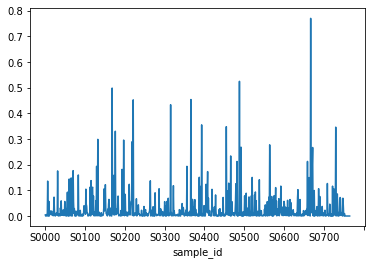

In [216]:
X.iloc[:,1].plot()

In [219]:
X.iloc[:,1] = rank_gauss(X.iloc[:,1].values)

In [220]:
X.iloc[:,1].describe()

count    7.660000e+02
mean     4.638007e-18
std      7.069691e-01
min     -2.273187e+00
25%     -4.762110e-01
50%     -1.496199e-17
75%      4.762110e-01
max      2.273187e+00
Name: (0, (0, 100]), dtype: float64

In [222]:
X.groupby(level=0, axis=1).apply(lambda x: rank_gauss(x.values))

m/z
0     [[-0.015041539035258436, -0.017356055741137074...
1     [[-0.017356055741137074, 0.01504153903525834, ...
10    [[-0.017356055741137074, 0.01504153903525834, ...
11    [[-0.017356055741137074, 0.012727183473267012,...
12    [[-0.017356055741137074, 0.01041296424335009, ...
                            ...                        
95    [[-0.017356055741137074, 0.017356055741137074,...
96    [[-0.017356055741137074, 0.012727183473267012,...
97    [[-0.017356055741137074, 0.01504153903525834, ...
98    [[-0.017356055741137074, 0.012727183473267012,...
99    [[-0.017356055741137074, 0.01504153903525834, ...
Length: 100, dtype: object

<AxesSubplot:xlabel='sample_id'>

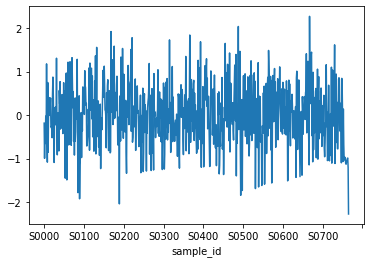

In [221]:
X.iloc[:,1].plot()

In [188]:
for col in train_df.columns:
    train_df[col] = rank_gauss(train_df[col].values)

<AxesSubplot:xlabel='sample_id'>

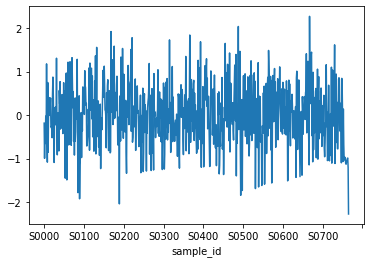

In [212]:
train_df.iloc[:,1].plot()

<AxesSubplot:xlabel='sample_id'>

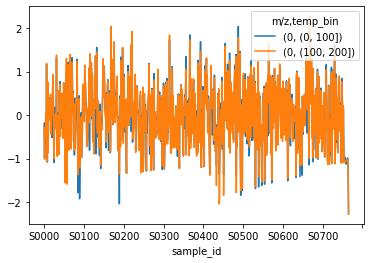

In [189]:
train_df.iloc[:,1:3].plot()

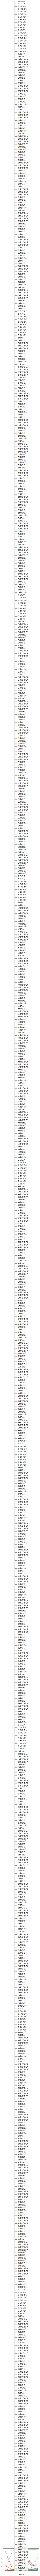

In [129]:
train_df[:5].plot();

In [159]:
train_df.groupby(level=0,axis=1).groups.keys()

dict_keys(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'])

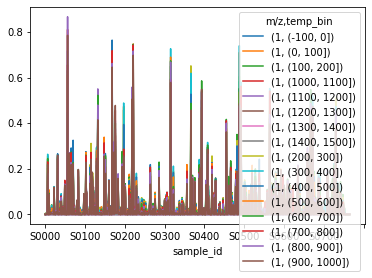

In [161]:
train_df.groupby(level=0,axis=1).get_group('1').plot();

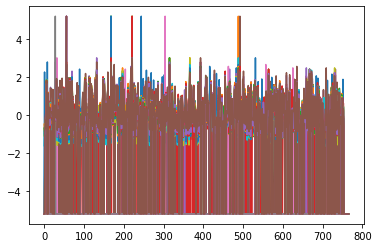

In [171]:
plt.plot(quantile_transform(train_df.groupby(level=0,axis=1).get_group('1'),output_distribution='normal',n_quantiles=10000));

<AxesSubplot:xlabel='sample_id'>

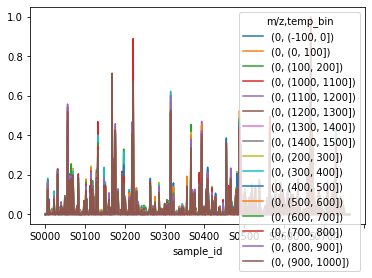

In [173]:
train_df.iloc[:,0:16].plot()

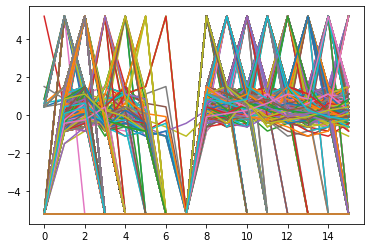

In [176]:
plt.plot(quantile_transform(train_df.iloc[:,0:16].T,n_quantiles=100,output_distribution='normal'));
plt.plot(quantile_transform(train_df.iloc[:,16:32].T,n_quantiles=100,output_distribution='normal'));
plt.plot(quantile_transform(train_df.iloc[:32:64],n_quantiles=100,output_distribution='normal'));